In [3]:
# Importing the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
pd.set_option('mode.chained_assignment', None)
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.feature_selection import mutual_info_regression

In [4]:
df = pd.read_csv("D:/UGP/datasets/new_precip.csv").drop(['nv','time_bnds','lat_bnds','lon_bnds'],axis=1).drop_duplicates().reset_index(drop=True)
evapr = pd.read_csv("D:/UGP/datasets/evapr.csv").sort_values(["lat", "lon","time"], ascending = (True, True,True))

# df.describe()
df['evapr'] = evapr['e']

In [6]:
time = pd.DatetimeIndex(df['time']).unique()

bhopal = df[(df['lat'] == 23.75) & (df['lon'] == 76.25 ) ]
kanpur = df[(df['lat'] == 26.25) & (df['lon'] == 81.25 ) ]
bombay = df[(df['lat'] == 18.75) & (df['lon'] == 71.25 ) ]

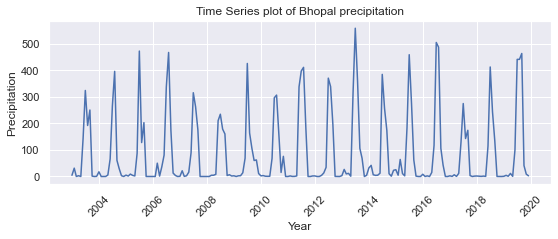

In [13]:


fig,ax = plt.subplots(figsize=(9,3))

plt.plot(time,bhopal['precip'], 'b') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of Bhopal precipitation')
plt.show()

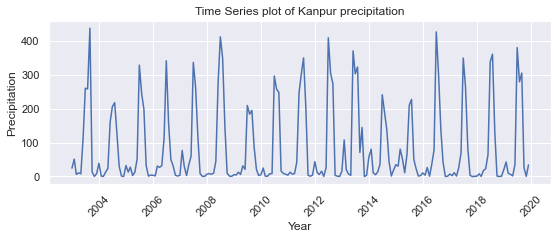

In [14]:


fig,ax = plt.subplots(figsize=(9,3))
plt.plot(time,kanpur["precip"], 'b') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of Kanpur precipitation')
plt.show()

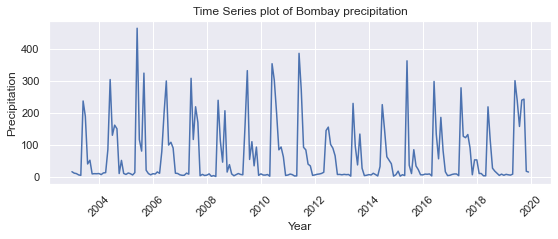

In [15]:


fig,ax = plt.subplots(figsize=(9,3))
plt.plot(time,bombay["precip"], 'b') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of Bombay precipitation')
plt.show()

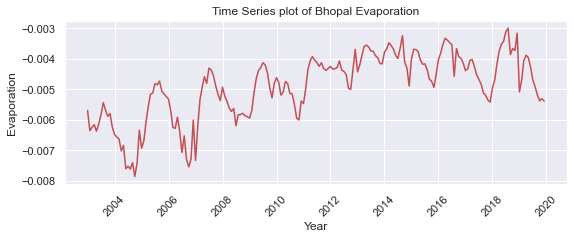

In [16]:
fig,ax = plt.subplots(figsize=(9,3))
plt.plot(time,bhopal["evapr"], 'r') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Evaporation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of Bhopal Evaporation')
plt.show()

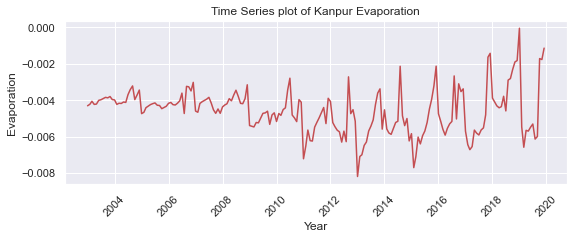

In [17]:
fig,ax = plt.subplots(figsize=(9,3))
plt.plot(time,kanpur["evapr"], 'r') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Evaporation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of Kanpur Evaporation')
plt.show()

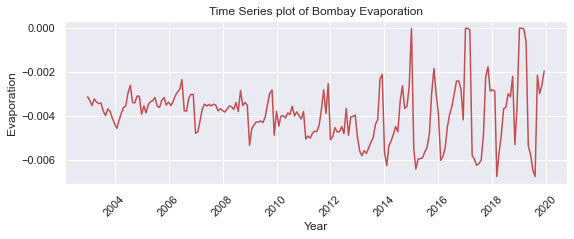

In [18]:
fig,ax = plt.subplots(figsize=(9,3))
plt.plot(time,bombay["evapr"], 'r') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Evaporation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of Bombay Evaporation')
plt.show()

In [13]:
# Loading the dataset into a single data frame

df = pd.DataFrame({"bhopal_precip":np.array(bhopal["precip"]),
                   "kanpur_precip":np.array(kanpur["precip"]),
                   "bombay_precip":np.array(bombay["precip"]),
                   "bhopal_evapr":np.array(bhopal['evapr']),
                   "kanpur_evapr":np.array(kanpur["evapr"]),
                   "bombay_evapr":np.array(bombay["evapr"])})

In [25]:
# Setting the time column as index of df

df.set_index(time,inplace=True)

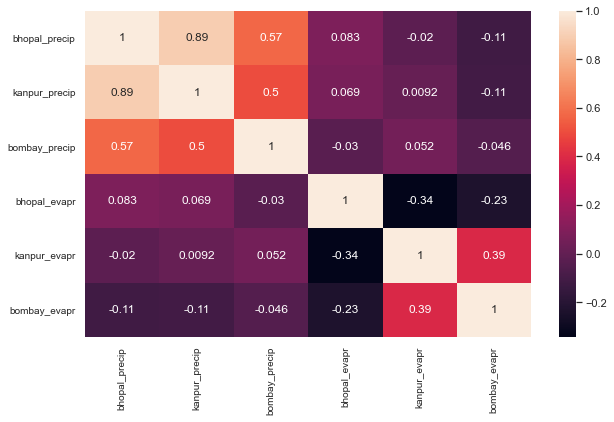

In [26]:
# Heatmap between all the variables of df

corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,annot = True,annot_kws={'size':12})
heatmap = plt.gcf()
heatmap.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

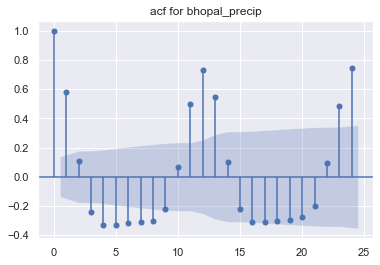

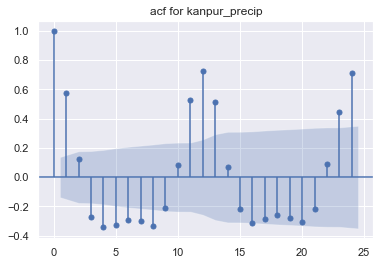

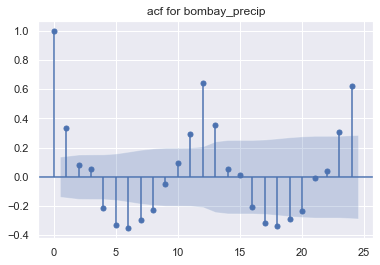

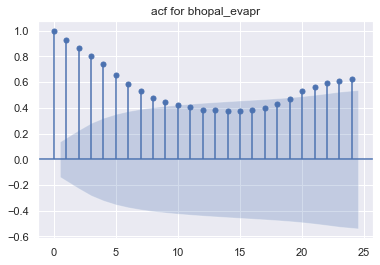

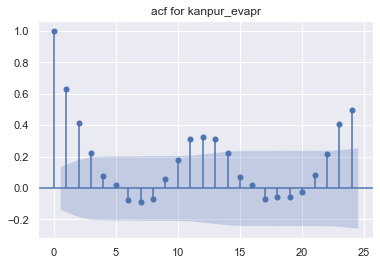

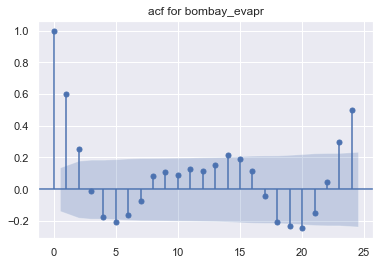

In [27]:
# Plotting the auto-correlation function for 24 months lag

for i in df:
    plot_acf(df[i],lags=24)
    plt.title("acf for "+i )
    plt.show()

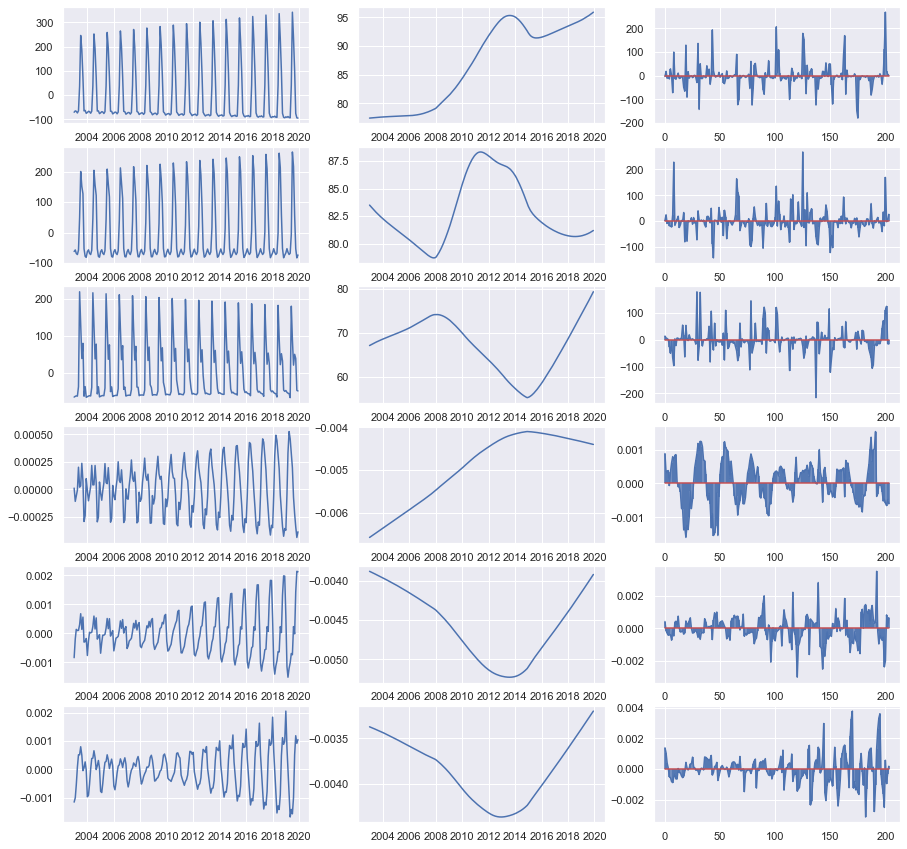

<Figure size 1008x432 with 0 Axes>

In [29]:
# Distributing signal into its seasonality, trend and residuals and storing the residuals in transformed data
 
fig, ax = plt.subplots(6,3,figsize=(15, 15))
plt.figure(figsize=(14,6))
transform_data = pd.DataFrame()
for i in range(6): 
    stl = STL(df.iloc[:,i], period = 12,seasonal=61 , trend = 121)
    res = stl.fit()
    transform_data[df.columns[i]] = res.resid
    ax[i,0].plot(res.seasonal)
    ax[i,1].plot(res.trend)
    ax[i,2].stem(res.resid , markerfmt='')
transform_data[df.columns[5]] = df.iloc[:,5] 

In [30]:
transform_data.describe()

,bhopal_precip,kanpur_precip,bombay_precip,bhopal_evapr,kanpur_evapr,bombay_evapr
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,-0.173603,-0.180104,-0.474484,0.000031,-0.000035,-0.003886
std,54.078315,49.280729,48.382623,0.000623,0.000833,0.001291
min,-178.577759,-141.649966,-215.811444,-0.001588,-0.002999,-0.006771
25%,-11.488516,-17.942272,-15.957299,-0.000394,-0.000475,-0.004739
50%,-3.735286,-5.482295,-1.846317,0.000048,-0.000066,-0.003790
75%,6.311236,11.965898,6.521698,0.000448,0.000444,-0.003292
max,268.503969,266.928360,179.558794,0.001529,0.003495,-0.000029


In [33]:
# This part is for doing a augmented dickey fuller test on transformed time series for testing stationarity
# https://www.statisticshowto.com/adf-augmented-dickey-fuller-test/ 

def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
print('Augmented Dickey-Fuller Test: Precipitation Bhopal')
augmented_dickey_fuller_statistics(transform_data['bhopal_precip'])
print('Augmented Dickey-Fuller Test: Precipitation Kanpur')
augmented_dickey_fuller_statistics(transform_data['kanpur_precip'])
print('Augmented Dickey-Fuller Test: Precipitation Bombay')
augmented_dickey_fuller_statistics(transform_data['bombay_precip'])
print('Augmented Dickey-Fuller Test: Evaporation Bhopal')
augmented_dickey_fuller_statistics(transform_data['bhopal_evapr'])
print('Augmented Dickey-Fuller Test: Evaporation Kanpur')
augmented_dickey_fuller_statistics(transform_data['kanpur_evapr'])
print('Augmented Dickey-Fuller Test: Evaporation Bombay')
augmented_dickey_fuller_statistics(transform_data['bombay_evapr'])



Augmented Dickey-Fuller Test: Precipitation Bhopal
ADF Statistic: -4.405065
p-value: 0.000291
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
Augmented Dickey-Fuller Test: Precipitation Kanpur
ADF Statistic: -8.368722
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Augmented Dickey-Fuller Test: Precipitation Bombay
ADF Statistic: -4.127313
p-value: 0.000873
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
Augmented Dickey-Fuller Test: Evaporation Bhopal
ADF Statistic: -5.781738
p-value: 0.000001
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
Augmented Dickey-Fuller Test: Evaporation Kanpur
ADF Statistic: -5.560659
p-value: 0.000002
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
Augmented Dickey-Fuller Test: Evaporation Bombay
ADF Statistic: -2.024703
p-value: 0.275848
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


In [34]:
# augmented dickey fuller test on initial time series

print('Augmented Dickey-Fuller Test: Precipitation Bhopal')
augmented_dickey_fuller_statistics(bhopal['precip'])
print('Augmented Dickey-Fuller Test: Precipitation Kanpur')
augmented_dickey_fuller_statistics(kanpur['precip'])
print('Augmented Dickey-Fuller Test: Precipitation Bombay')
augmented_dickey_fuller_statistics(bombay['precip'])
print('Augmented Dickey-Fuller Test: Evaporation Bhopal')
augmented_dickey_fuller_statistics(bhopal['evapr'])
print('Augmented Dickey-Fuller Test: Evaporation Kanpur')
augmented_dickey_fuller_statistics(kanpur['evapr'])
print('Augmented Dickey-Fuller Test: Evaporation Bombay')
augmented_dickey_fuller_statistics(bombay['evapr'])

Augmented Dickey-Fuller Test: Precipitation Bhopal
ADF Statistic: -3.314656
p-value: 0.014236
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
Augmented Dickey-Fuller Test: Precipitation Kanpur
ADF Statistic: -3.511939
p-value: 0.007686
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
Augmented Dickey-Fuller Test: Precipitation Bombay
ADF Statistic: -2.901115
p-value: 0.045218
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Augmented Dickey-Fuller Test: Evaporation Bhopal
ADF Statistic: -2.723846
p-value: 0.070002
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Augmented Dickey-Fuller Test: Evaporation Kanpur
ADF Statistic: -2.351926
p-value: 0.155767
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
Augmented Dickey-Fuller Test: Evaporation Bombay
ADF Statistic: -2.024703
p-value: 0.275848
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


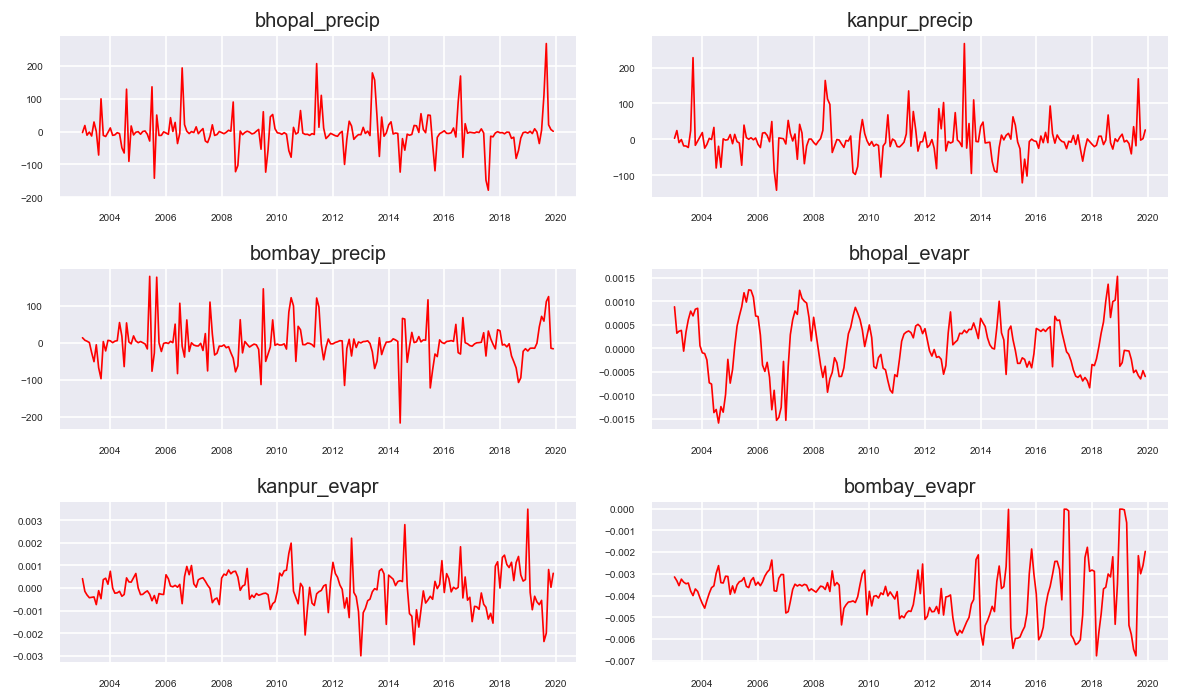

In [36]:
# Plotting the transformed time series for each variable

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    d = transform_data[transform_data.columns[i]]
    ax.plot(d, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()

In [37]:
# Performing the granger causality test on the transformed time series for max lag of 12 months
# https://www.statisticshowto.com/granger-causality/ 

maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset
grangers_causality_matrix(transform_data, variables = transform_data.columns)

,bhopal_precip_x,kanpur_precip_x,bombay_precip_x,bhopal_evapr_x,kanpur_evapr_x,bombay_evapr_x
bhopal_precip_y,1.0000,0.0715,0.0214,0.5649,0.0086,0.5647
kanpur_precip_y,0.1058,1.0000,0.1816,0.3080,0.1377,0.6697
bombay_precip_y,0.1528,0.0092,1.0000,0.1304,0.1765,0.0288
bhopal_evapr_y,0.0900,0.0533,0.0153,1.0000,0.4872,0.1413
kanpur_evapr_y,0.0625,0.7481,0.0820,0.1323,1.0000,0.0031
bombay_evapr_y,0.6960,0.8376,0.2383,0.0655,0.0006,1.0000


In [34]:
# Calculating Mutual Information between the variables

mi = pd.DataFrame(columns=['sla_io' , 'sla_as' ,'sla_bb' , 'enso'])
mi = mi.append(pd.DataFrame(mutual_info_regression(transform_data.iloc[:,4:], transform_data.iloc[:,0] , discrete_features=False).reshape(1,-1), columns=list(mi)), ignore_index=True)
mi = mi.append(pd.DataFrame(mutual_info_regression(transform_data.iloc[:,4:], transform_data.iloc[:,1] , discrete_features=False).reshape(1,-1), columns=list(mi)), ignore_index=True)
mi = mi.append(pd.DataFrame(mutual_info_regression(transform_data.iloc[:,4:], transform_data.iloc[:,2] , discrete_features=False).reshape(1,-1), columns=list(mi)), ignore_index=True)
mi = mi.append(pd.DataFrame(mutual_info_regression(transform_data.iloc[:,4:], transform_data.iloc[:,3] , discrete_features=False).reshape(1,-1), columns=list(mi)), ignore_index=True)
mi['region'] = pd.Series(['precip_SE' , 'precip_SW' , 'precip_NE' , 'precip_NW'])
mi.set_index("region")

,sla_io,sla_as,sla_bb,enso
region,,,,
precip_SE,0.0,0.000000,0.024771,0.000000
precip_SW,0.0,0.028973,0.000000,0.000000
precip_NE,0.0,0.000000,0.000000,0.154879
precip_NW,0.0,0.080103,0.008262,0.010780
